In [9]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [27]:

from skimage.segmentation import slic, mark_boundaries
from skimage.color import label2rgb, rgb2gray
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from skimage.segmentation import mark_boundaries
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
import glob
import keras
from keras import layers
from keras.layers import Dense
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
import cv2
from cv2 import imread, createCLAHE
import glob
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from IPython.display import clear_output
from keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_erosion, disk
import keras.backend as K
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel
from tqdm import tqdm
from keras.losses import Loss
from keras.callbacks import TensorBoard
from scipy.ndimage import distance_transform_edt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.applications import VGG19
from keras.utils import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

In [31]:
# image_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1-2_Training_Input/*.png")
# mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1_Training_GroundTruth/*.png")
# image_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/kvasir-seg (1)/Kvasir-SEG/images/*.png")
# mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/kvasir-seg (1)/Kvasir-SEG/masks/*.png")
image_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/cvc-clinic/PNG/Original/*.png")
mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/cvc-clinic/PNG/Ground Truth/*.png")
# image_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/PolypDataset/NewTR_image/*.png")
# mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/PolypDataset/NewTR_mask/*.png")

In [29]:
# initialize empty arrays to hold the images and masks
images = []
masks = []
images_superpixel = []
binary_masks = []
masks_superpixel = []
masks_result = []
binary = []

In [33]:

# Define augmentation transform
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Input directory containing your original images
input_dir = "/home/somayeh/PycharmProjects/superpixel_segmentation/cvc-clinic/PNG/Original/"  # Replace with your actual data directory

# Output directory to save augmented images
output_dir = "augmented_data"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List all image files in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]

# Number of augmentations to generate for each image
num_augmentations = 5  # You can adjust this number as needed

# Loop through each image file
for img_file in image_files:
    # Load the image
    img = load_img(os.path.join(input_dir, img_file))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Generate augmented images
    i = 0
    for batch in datagen.flow(x, batch_size=1):
        augmented_image = array_to_img(batch[0])

        # Save the augmented image with a unique filename
        augmented_filename = f"augmented_{img_file.split('.')[0]}_aug_{i}.jpg"
        augmented_image.save(os.path.join(output_dir, augmented_filename))

        i += 1
        if i >= num_augmentations:
            break

print("Data augmentation complete.")

Data augmentation complete.


In [34]:
# Define augmentation transform
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Input directory containing your original images
input_dir = "/home/somayeh/PycharmProjects/superpixel_segmentation/cvc-clinic/PNG/Ground Truth/"  # Replace with your actual data directory

# Output directory to save augmented images
output_dir = "augmented_data_mask"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List all image files in the input directory
image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]

# Number of augmentations to generate for each image
num_augmentations = 5  # You can adjust this number as needed

# Loop through each image file
for img_file in image_files:
    # Load the image
    img = load_img(os.path.join(input_dir, img_file))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Generate augmented images
    i = 0
    for batch in datagen.flow(x, batch_size=1):
        augmented_image = array_to_img(batch[0])

        # Save the augmented image with a unique filename
        augmented_filename = f"augmented_{img_file.split('.')[0]}_aug_{i}.jpg"
        augmented_image.save(os.path.join(output_dir, augmented_filename))

        i += 1
        if i >= num_augmentations:
            break

print("Data augmentation complete.")

Data augmentation complete.


In [5]:
def ground_truth_superpixel_1(img, ground_truth):
    # Perform superpixel segmentation
    num_segments = 800
    segments = slic(img, n_segments=num_segments, compactness=10)
    # segments = felzenszwalb(img, scale=20, sigma=0.5, min_size=30)
    # segments = quickshift(img, kernel_size=1, max_dist=2.5, ratio=0.5)

    # gradient = sobel(rgb2gray(img))
    # segments = watershed(gradient, markers=800, compactness=0.001)

    image_superpixel = label2rgb(segments, img, kind='avg')
    image_superpixel = rgb2gray(image_superpixel)
    num_superpixels = len(np.unique(segments))
    # print(f'The image contains {num_superpixels} superpixels.')

    image_boundaries = mark_boundaries(img, segments, color=(255, 0, 0))
    labels = segments.astype(np.int32)

    # Overlay superpixels with ground truth
    inside_mask = (ground_truth == 255)  # white pixels in ground truth are inside the chest region
    outside_mask = (ground_truth == 0)  # black pixels in ground truth are outside the chest region
    boundary_mask = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, np.ones((5, 5), np.uint8)) > 0

    inside_superpixels = set(np.unique(labels[inside_mask]))
    outside_superpixels = set(np.unique(labels[outside_mask]))
    boundary_superpixels = set(np.unique(labels[boundary_mask]))

    # Exclude boundary superpixels
    valid_superpixels = list(outside_superpixels.union(inside_superpixels) - boundary_superpixels)

    for label in boundary_superpixels:
        mask = (labels == label)
        # Check if the superpixel intersects with the boundary
        if np.any(mask[0, :]) or np.any(mask[-1, :]) or np.any(mask[:, 0]) or np.any(mask[:, -1]):
            boundary_mask_ = binary_erosion(boundary_mask,
                                            disk(
                                                3))  # erode the boundary mask to avoid including partial boundary pixels
            valid_superpixels = list(outside_superpixels.union(inside_superpixels) - set(labels[boundary_mask_]))

    num_segments_result = len(np.unique(valid_superpixels))
    # print(f'The result image contains {num_segments_result} superpixels.')

    # Assign labels and color superpixels
    result = np.zeros_like(img)
    inside_labels = []
    outside_labels = []
    for label in valid_superpixels:
        mask = (labels == label)
        if label in inside_superpixels:
            color = (255, 255, 255)  # yellow for inside superpixels
            inside_labels.append(label)
        else:
            color = (0, 0, 0)  # blue for outside superpixels
            outside_labels.append(label)
        result[mask] = color

    # Set background class for the omitted superpixels
    background_mask = (ground_truth == 0)
    result[background_mask] = (0, 0, 0)

    # # Show number of labels in the result image
    # print(
    #     f"The result image contains {len(inside_labels)} inside superpixels and {len(outside_labels)} outside superpixels.")

    # Visualize the result
    # cv2.imshow('Image', img)
    # cv2.imshow('Ground Truth', ground_truth)
    # cv2.imshow('Superpixels',
    #            cv2.cvtColor(cv2.normalize(labels, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U), cv2.COLOR_GRAY2BGR))
    # cv2.imshow('Result', result)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    #
    # fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    # ax[0].imshow(image_superpixel)
    # ax[0].set_title('Superpixel image')
    # ax[1].imshow(ground_truth, cmap='gray')
    # ax[1].set_title('Binary ground truth')
    # ax[2].imshow(image_boundaries)
    # ax[2].set_title('Mark boundaries')
    # ax[3].imshow(result)
    # ax[3].set_title('Ground truth result')
    # plt.show()
    return result

In [6]:
def ground_truth_superpixel_2(img, ground_truth, boundary_weight=0.5):
    # Perform superpixel segmentation
    num_segments = 400
    segments = slic(img, n_segments=num_segments, compactness=10)

    # Overlay superpixels with ground truth
    inside_mask = (ground_truth == 255)  # white pixels in ground truth are inside the chest region
    outside_mask = (ground_truth == 0)  # black pixels in ground truth are outside the chest region
    boundary_mask = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, np.ones((5, 5), np.uint8)) > 0

    inside_superpixels = set(np.unique(segments[inside_mask]))
    outside_superpixels = set(np.unique(segments[outside_mask]))
    boundary_superpixels = set(np.unique(segments[boundary_mask]))

    # Exclude boundary superpixels
    valid_superpixels = list(outside_superpixels.union(inside_superpixels) - boundary_superpixels)

    for label in boundary_superpixels:
        mask = (segments == label)
        # Check if the superpixel intersects with the boundary
        if np.any(mask[0, :]) or np.any(mask[-1, :]) or np.any(mask[:, 0]) or np.any(mask[:, -1]):
            boundary_mask_ = cv2.erode(boundary_mask.astype(np.uint8), np.ones((3, 3), np.uint8))
            valid_superpixels = list(outside_superpixels.union(inside_superpixels) - set(segments[boundary_mask_.astype(bool)]))

    num_segments_result = len(np.unique(valid_superpixels))

    # Assign labels and color superpixels
    result = np.zeros_like(img)
    inside_labels = []
    outside_labels = []
    for label in valid_superpixels:
        mask = (segments == label)
        if label in inside_superpixels:
            color = (255, 255, 255)  # white for inside superpixels
            inside_labels.append(label)
        else:
            color = (0, 0, 0)  # black for outside superpixels
            outside_labels.append(label)
        result[mask] = color

    # Set background class for the omitted superpixels
    background_mask = (ground_truth == 0)
    result[background_mask] = (0, 0, 0)

    # Compute weights for boundary-intersecting superpixels using distance transform
    boundary_intersecting_superpixels = set(boundary_superpixels).intersection(valid_superpixels)
    distance_transform = distance_transform_edt(boundary_mask.astype(np.uint8))
    for label in boundary_intersecting_superpixels:
        mask = (segments == label)
        weights = 1.0 - (distance_transform[mask] / np.max(distance_transform))
        weights = np.expand_dims(weights, axis=-1)  # Add extra dimension for broadcasting
        result[mask] = weights * boundary_weight

    return result.astype(np.uint8)

In [7]:
def ground_truth_superpixel_3(img, ground_truth):
    # Perform SLIC superpixel segmentation
    num_segments = 800
    segments = slic(img, n_segments=num_segments, compactness=10)
    # segments = felzenszwalb(img, scale=20, sigma=0.5, min_size=30)
    # segments = quickshift(img, kernel_size=1, max_dist=2.5, ratio=0.5)

    # Find superpixels intersecting with the image boundaries
    boundary_mask = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, np.ones((5, 5), np.uint8)) > 0
    boundary_superpixels = set(segments[boundary_mask])

    # Show the number of superpixels with intersection with image boundaries
    num_boundary_superpixels = len(boundary_superpixels)
    # print(f'The number of superpixels with intersection with image boundaries: {num_boundary_superpixels}')

    # Overlay superpixels with ground truth
    labels = segments.astype(np.int32)

    inside_mask = (ground_truth == 255)  # white pixels in ground truth are inside the chest region
    outside_mask = (ground_truth == 0)  # black pixels in ground truth are outside the chest region

    inside_superpixels = set(np.unique(labels[inside_mask]))
    outside_superpixels = set(np.unique(labels[outside_mask]))

    # Assign labels and color superpixels
    result = np.zeros_like(img)
    for label in outside_superpixels:
        mask = (labels == label)
        result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels outside the boundary

    for label in inside_superpixels:
        mask = (labels == label)
        result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels inside the boundary

    for label in boundary_superpixels:
        mask = (labels == label)
        num_pixels_inside = np.sum(mask & inside_mask)
        num_pixels_outside = np.sum(mask & outside_mask)

        if num_pixels_outside > num_pixels_inside:
            result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels with more pixels outside the boundary
        elif num_pixels_outside < num_pixels_inside:
            result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels with more pixels inside the boundary
        else:
            d1 = cv2.distanceTransform((mask & outside_mask).astype(np.uint8), cv2.DIST_L2, 5)
            d2 = cv2.distanceTransform((mask & inside_mask).astype(np.uint8), cv2.DIST_L2, 5)

            d1_sorted = np.sort(d1[mask & boundary_mask])
            d2_sorted = np.sort(d2[mask & boundary_mask])

            threshold_idx = len(d1_sorted) // 2
            if np.sum(d1_sorted[:threshold_idx]) > np.sum(d1_sorted[threshold_idx:]):
                result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels with larger distance to outside
            else:
                result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels with larger distance to inside

    # cv2.imshow('Result', result)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return result

In [8]:
from skimage.morphology import disk
def ground_truth_superpixel_4(img, ground_truth):
    # Perform SLIC superpixel segmentation
    num_segments = 800
    segments = slic(img, n_segments=num_segments, compactness=10)

    # Find superpixels intersecting with the image boundaries
    boundary_mask = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, np.ones((5, 5), np.uint8)) > 0
    boundary_superpixels = set(segments[boundary_mask])

    # Show the number of superpixels with intersection with image boundaries
    num_boundary_superpixels = len(boundary_superpixels)
    print(f'The number of superpixels with intersection with image boundaries: {num_boundary_superpixels}')

    # Overlay superpixels with ground truth
    labels = segments.astype(np.int32)

    inside_mask = (ground_truth == 255)  # white pixels in ground truth are inside the chest region
    outside_mask = (ground_truth == 0)  # black pixels in ground truth are outside the chest region

    inside_superpixels = set(np.unique(labels[inside_mask]))
    outside_superpixels = set(np.unique(labels[outside_mask]))

    # Assign labels and color superpixels
    result = np.zeros_like(img)
    for label in outside_superpixels:
        mask = (labels == label)
        result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels outside the boundary

    for label in inside_superpixels:
        mask = (labels == label)
        result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels inside the boundary

    for label in boundary_superpixels:
        mask = (labels == label)
        num_pixels_inside = np.sum(mask & inside_mask)
        num_pixels_outside = np.sum(mask & outside_mask)

        if num_pixels_outside > num_pixels_inside:
            result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels with more pixels outside the boundary
        elif num_pixels_outside < num_pixels_inside:
            result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels with more pixels inside the boundary
        else:
            d1 = cv2.distanceTransform((mask & outside_mask).astype(np.uint8), cv2.DIST_L2, 5)
            d2 = cv2.distanceTransform((mask & inside_mask).astype(np.uint8), cv2.DIST_L2, 5)

            # Calculate probabilities for each pixel in the superpixel
            probabilities_bg = d2 / (d1 + d2)[:, :, np.newaxis]
            probabilities_fg = d1 / (d1 + d2)[:, :, np.newaxis]

            # Create color arrays for each pixel based on probabilities
            colors_bg = probabilities_bg * 255
            colors_fg = probabilities_fg * 255

            # Assign labels based on probabilities for each pixel individually
            result[mask] = np.where(probabilities_bg > probabilities_fg, colors_bg, colors_fg)

    return result


In [9]:
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

In [10]:
def precision(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true_flat * y_pred_flat, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_flat, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    return precision


In [11]:
def sensitivity(gt_mask, pred_mask):
    """
    Computes sensitivity (recall) of the predicted segmentation mask
    given the ground truth mask.

    Args:
        gt_mask (np.array): binary ground truth segmentation mask.
        pred_mask (np.array): binary predicted segmentation mask.

    Returns:
        float: sensitivity score.
    """
    gt_mask_flat = K.flatten(gt_mask)
    pred_mask_flat = K.flatten(pred_mask)

    # compute true positive (TP) and false negative (FN) counts
    TP = K.sum(gt_mask_flat * pred_mask_flat)
    FN = K.sum(gt_mask_flat * (1 - pred_mask_flat))

    # compute sensitivity (recall)
    if TP + FN == 0:
        sensitivity_score = 0.0
    else:
        sensitivity_score = TP / (TP + FN)

    return sensitivity_score

In [12]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # print(y_true.shape)
    # print(y_pred.shape)
    intersection = K.sum(y_true_f * y_pred_f)
    # print(y_pred)
    # print(y_true)
    # print(np.amax(y_pred))
    # print(np.amax(y_true))
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [13]:
def dice_coef_1(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [14]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred,1)

In [15]:
def binary_to_soft_label(binary_mask, threshold_value=156):
    binary_mask = binary_mask.astype(np.uint8)

    # Compute the distance transform
    dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 3)

    # Calculate the maximum distance value
    max_dist = np.amax(dist_transform)

    # Normalize the distance transform to [0, 1]
    normalized_dist = (dist_transform / max_dist) * 255.

    normalized_dist = normalized_dist.astype(np.uint8)

    _, th_img = cv2.threshold(normalized_dist, threshold_value, 255, cv2.THRESH_OTSU)

    return th_img


In [16]:
batch_size = 8
threshold_value = 128
def data_generator(image_paths, mask_paths, batch_size):

    assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."

    num_samples = len(image_paths)
    print("Number of images:", num_samples)
    num_masks = len(mask_paths)
    print("Number of masks:", num_masks)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i : i + batch_size]
            batch_images = []
            batch_masks = []

            for index in batch_indices:
                image_path = image_paths[index]
                mask_path = mask_paths[index]

                img = cv2.imread(image_path)
                img = cv2.resize(img, (256, 256))

                filename = os.path.join("/home/somayeh/PycharmProjects/superpixel_segmentation/"
                                        "newgt/newgt_superpixel_CVC_slic800", os.path.basename(mask_path))
                if not os.path.exists(filename):

                    mask = cv2.imread(mask_path,0)
                    mask = cv2.resize(mask, (256, 256))

                    result = ground_truth_superpixel_1(img, mask)
                    # result = ground_truth_superpixel_3(img, mask)

                    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
                    # plt.subplot(1, 2, 2)
                    # plt.imshow(result)
                    # plt.title("hggh")

                    # soft_label = binary_to_soft_label(result, threshold_value=threshold_value)
                    # cv2.imshow("kjkj",soft_label)
                    # cv2.waitKey(0)
                    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

                    cv2.imwrite(filename, result)

                else:
                    result = cv2.imread(filename, 0)
                # print(result.type)
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # soft_label = binary_to_soft_label(result)

                # normalize the image and mask to have values between 0 and 1
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img / 255.0
                result= result/ 255.0
                # result = result / 255.0
                # print(soft_label.shape)
                # cv2.imshow("dfg", soft_label)
                # cv2.waitKey(0)
                # Append the preprocessed data to the respective lists

                batch_images.append(img)
                batch_masks.append(result)

            # Yield the batch data
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)

            # Visualize the images and masks in the batch
            # for j in range(batch_images.shape[0]):
            #     plt.subplot(1, 2, 1)
            #     plt.imshow(batch_images[j])
            #     plt.title("Image")
            #
            #     plt.subplot(1, 2, 2)
            #     plt.imshow(batch_masks[j])
            #     plt.title("Mask")
            #
            #     plt.show()

            yield batch_images, batch_masks
# #
generator = data_generator(image_paths, mask_paths, 1)

for _,imgpath in tqdm(enumerate(image_paths)):
   batch = next(generator)


0it [00:00, ?it/s]

Number of images: 612
Number of masks: 612


612it [03:56,  2.58it/s]


In [17]:
assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."
# Split the data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.1, random_state=42
)

# Define the batch size
batch_size = 8

# Create separate generators for training and validation sets
train_generator = data_generator(train_image_paths, train_mask_paths, batch_size)
val_generator = data_generator(val_image_paths, val_mask_paths, batch_size)

# batch_size = 5  # Number of batches to visualize

# for _ in range(batch_size):
#     batch = next(train_generator)

# Determine the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

print(train_steps_per_epoch)
print(val_steps_per_epoch)


68
7


In [18]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# def encoder2(inputs):
#     skip_connections = []
#
#     output = DenseNet121(include_top=False, weights='imagenet')(inputs)
#     model = tf.keras.models.Model(inputs, output)
#
#     names = ["input_2", "conv1/relu", "pool2_conv", "pool3_conv"]
#     for name in names:
#         skip_connections.append(model.get_layer(name).output)
#     output = model.get_layer("pool4_conv").output
#
#     return output, skip_connections

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    # outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs2)
    return model

In [19]:
def build_unet(input_size=(256,256,3)):

    inputs  = Input(input_size)

    conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool5)
    conv6 = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)


    up7 = layers.concatenate([Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(conv6), conv5], axis=3)


    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)


    up8 = layers.concatenate([Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(conv7), conv4], axis=3)

    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.concatenate([Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv8), conv3], axis=3)

    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv9)

    up10 = layers.concatenate([Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv9), conv2], axis=3)

    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)

    up11 = layers.concatenate([Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv10), conv1], axis=3)

    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(up11)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv11)

    conv12 = Conv2D(1, (1,1), activation='relu')(conv11)

    return Model(inputs=[inputs], outputs=[conv12])



In [20]:
# from keras.applications import ResNet101V2
#
# def ResNet101(input_shape=(224, 224,3)):
#
#     base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(None, None, 3))
#
#     # Add additional layers on top of the base model
#     x = base_model.output
#     # x = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Segmentation output with a single channel
#     # x = base_model.output
#     # x = Conv2DTranspose(1, (1, 1), activation='sigmoid')(x)  # Segmentation output with a single channel
#     # Add additional layers on top of the base model
#
#     # Add Conv2DTranspose layers to upscale the output to the desired size (224, 224)
#     x = Conv2DTranspose(1024, (3, 3), strides=(2, 2), padding='same')(x)
#     x = Activation('relu')(x)
#     x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x)
#     x = Activation('relu')(x)
#     x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
#     x = Activation('relu')(x)
#     x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
#     x = Activation('relu')(x)
#     x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
#     x = Activation('relu')(x)
#     x = Conv2D(1, (1, 1), activation='sigmoid')(x)
#
#     model = Model(inputs=base_model.input, outputs=x)
#
#     return model

In [21]:
!rm -rf '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [22]:
%load_ext tensorboard
log_folder = '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [23]:
# callbacks = [TensorBoard(log_dir=log_folder,
#                          histogram_freq=1,
#                          write_graph=True,
#                          write_images=True,
#                          update_freq='epoch',
#                          profile_batch=2,
#                          embeddings_freq=1)]


In [24]:
#  callbacks, early stopping and reduced LR
# weight_path="{}_soft_label.best.hdf5".format('cxr_reg')
# weight_path="{}_Unet_soft_label_skin_slic800.best.hdf5".format('cxr_reg')
# weight_path="{}_doubel_Unet_soft_label_andoscopy_slic800.best.hdf5".format('cxr_reg')
# weight_path="{}_double_Unet_superpixel_skin_quick_shift.best.hdf5".format('cxr_reg')
# weight_path="{}_double_Unet_superpixel_skin_sorted_list_slic800.best.hdf5".format('cxr_reg')
# weight_path="{}_double_Unet_superpixel_skin_slic800.best.hdf5".format('cxr_reg')
# weight_path="{}_Unet_superpixel_polyp_slic800.best.hdf5".format('cxr_reg')
weight_path="{}_Unet_superpixel_cvc_slic800.best.hdf5".format('cxr_reg')


checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-5)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=10) # probably needs to be more patient, but kaggle time is limited
log_folder = '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

tbcallback = TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)

callbacks_list = [checkpoint, early, reduceLROnPlat, tbcallback]

2023-09-21 10:30:00.553038: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-09-21 10:30:00.553088: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-09-21 10:30:00.654290: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-09-21 10:30:00.655039: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/cv2/../../lib64:
2023-09-21 10:30:00.691709: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-09-21 10:30:00.692005: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [25]:
from keras.optimizers import Adamax
model =build_unet(input_size=(256,256,3))
opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001)
model.compile(optimizer=opt, loss= dice_coef_loss,metrics= [dice_coef, precision, iou, sensitivity] ,run_eagerly=True)
model.summary()

2023-09-21 10:33:05.748465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 10:33:05.843976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 10:33:05.844176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 10:33:05.845013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [26]:

loss_history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    epochs=50,
    callbacks =callbacks_list
)

# model.save("double_unet_super_pixel_Skin_slic800.h5")
model.save("unet_super_pixel_cvc_slic800.h5")



/tmp/ipykernel_11739/1196258248.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = model.fit_generator(


Number of images: 550
Number of masks: 550
Epoch 1/50


2023-09-21 10:34:36.423191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2023-09-21 10:34:37.373822: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-09-21 10:34:37.375662: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-09-21 10:34:37.375674: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-09-21 10:34:37.375795: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

2023-09-21 10:34:42.180992: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-09-21 10:34:42.599748: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-09-21 10:34:42.916738: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

 1/68 [..............................] - ETA: 14:56 - loss: 0.9286 - dice_coef: 0.0714 - precision: 0.0000e+00 - iou: 0.0370 - sensitivity: 0.0618

2023-09-21 10:34:47.305907: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-09-21 10:34:47.458363: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-09-21 10:34:47.458445: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


 2/68 [..............................] - ETA: 1:06 - loss: 0.9196 - dice_coef: 0.0804 - precision: 0.0000e+00 - iou: 0.0419 - sensitivity: 0.0693 

2023-09-21 10:34:48.369196: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-09-21 10:34:48.380109: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-09-21 10:34:48.439500: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 1072 callback api events and 1080 activity events. 
2023-09-21 10:34:48.449589: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-09-21 10:34:48.452590: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board/plugins/profile/2023_09_21_10_34_48/somayeh-ASUS-TUF-Gaming-F15-FX506HCB-FX506HCB.xplane.pb


68/68 [==============================] - ETA: 0s - loss: 0.7840 - dice_coef: 0.2160 - precision: 0.0929 - iou: 0.1266 - sensitivity: 2.5864Number of images: 62
Number of masks: 62

Epoch 1: val_loss improved from inf to 0.54047, saving model to cxr_reg_Unet_superpixel_cvc_slic800.best.hdf5
68/68 [==============================] - 41s 419ms/step - loss: 0.7840 - dice_coef: 0.2160 - precision: 0.0929 - iou: 0.1266 - sensitivity: 2.5864 - val_loss: 0.5405 - val_dice_coef: 0.4595 - val_precision: 0.1713 - val_iou: 0.3334 - val_sensitivity: 3.8256 - lr: 1.0000e-04
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 0.6315 - dice_coef: 0.3681 - precision: 0.1540 - iou: 0.2819 - sensitivity: 441.8979
Epoch 2: val_loss improved from 0.54047 to 0.39541, saving model to cxr_reg_Unet_superpixel_cvc_slic800.best.hdf5
68/68 [==============================] - 28s 366ms/step - loss: 0.6315 - dice_coef: 0.3681 - precision: 0.1540 - iou: 0.2819 - sensitivity: 441.8979 - val_loss: 0.3954

In [36]:
test_images = []
ground_truth_test_images = []

# define the paths to the images and their ground truths
# test_paths = glob.glob('/home/somayeh/PycharmProjects/pythonProject2/ISBI2016_ISIC_Part1_Test_Data/*.png')
# test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/pythonProject2/ISBI2016_ISIC_Part1_Test_GroundTruth/*.png")

test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/cvc-test/archive (3)/PNG/Original/*.png")
test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/cvc-test/archive (3)/PNG/Ground Truth/*.png")


# test_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/dataset/test/test_images/*.png')
# test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/dataset/test/test_masks/*.png")

(612, 256, 256, 3)
(612, 256, 256)
612/612 [==============================] - 19s 30ms/step
(612, 256, 256, 1)
(612, 256, 256, 1)
(612, 256, 256)
Dices: [<tf.Tensor: shape=(), dtype=float64, numpy=0.7829653646130521>, <tf.Tensor: shape=(), dtype=float64, numpy=0.526592300037216>, <tf.Tensor: shape=(), dtype=float64, numpy=9.309171834169699e-05>, <tf.Tensor: shape=(), dtype=float64, numpy=0.11354780137830207>, <tf.Tensor: shape=(), dtype=float64, numpy=0.8859057430198505>, <tf.Tensor: shape=(), dtype=float64, numpy=0.5429435441185811>, <tf.Tensor: shape=(), dtype=float64, numpy=0.000589921366951911>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0002152456374773887>, <tf.Tensor: shape=(), dtype=float64, numpy=0.00041081523463994054>, <tf.Tensor: shape=(), dtype=float64, numpy=0.6061941846994067>, <tf.Tensor: shape=(), dtype=float64, numpy=0.00048503154607133954>, <tf.Tensor: shape=(), dtype=float64, numpy=0.18269880472518>, <tf.Tensor: shape=(), dtype=float64, numpy=0.44230037188493626>,

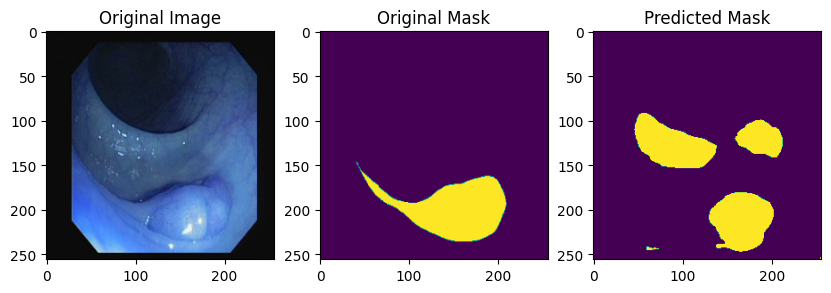

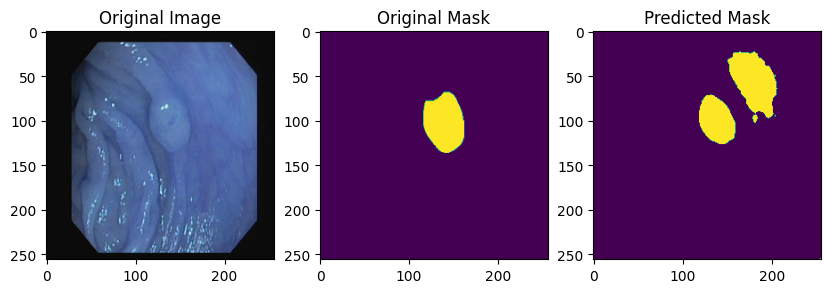

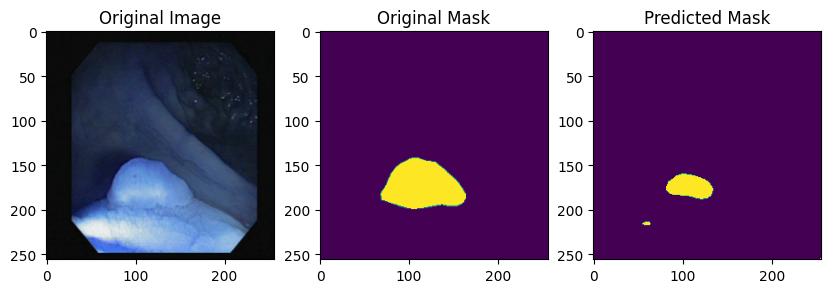

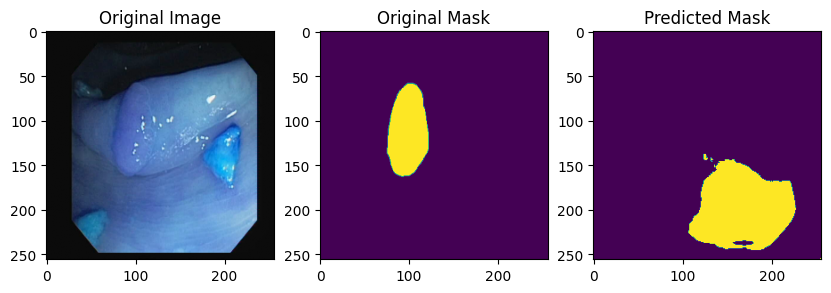

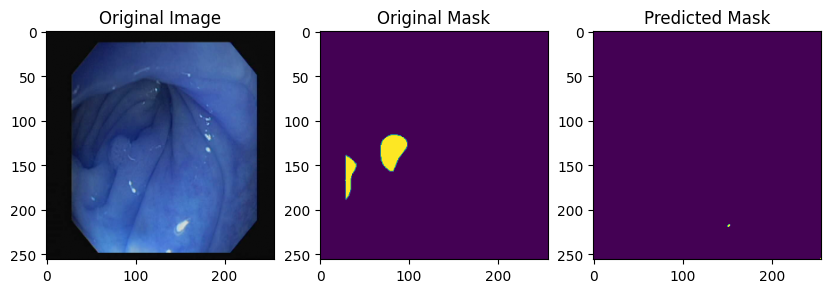

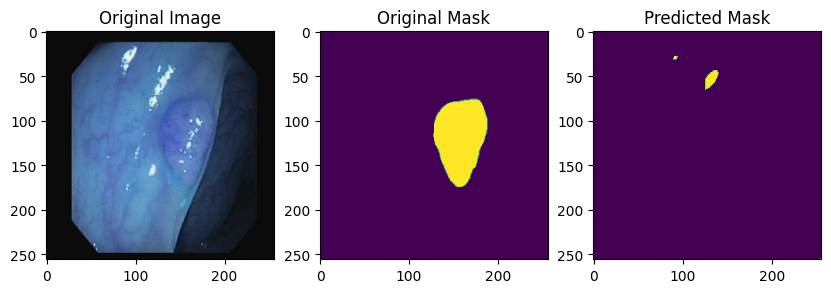

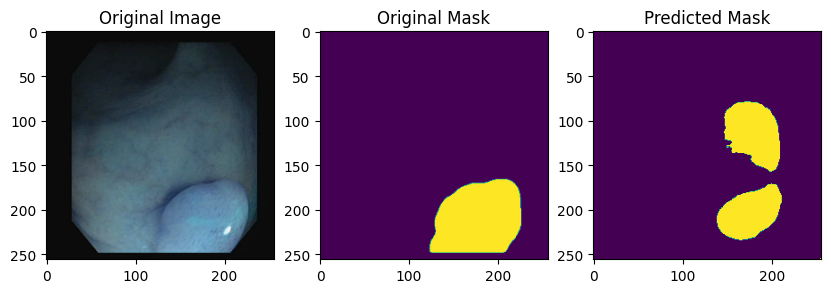

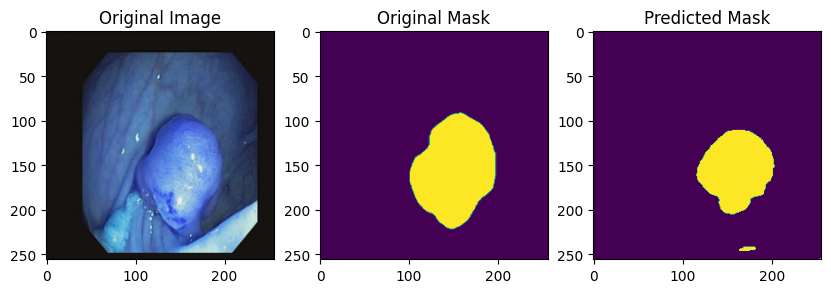

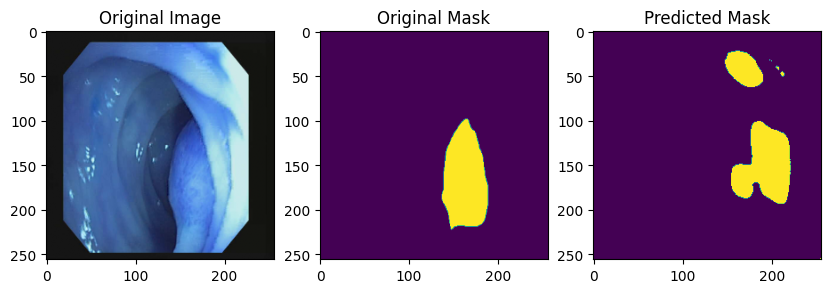

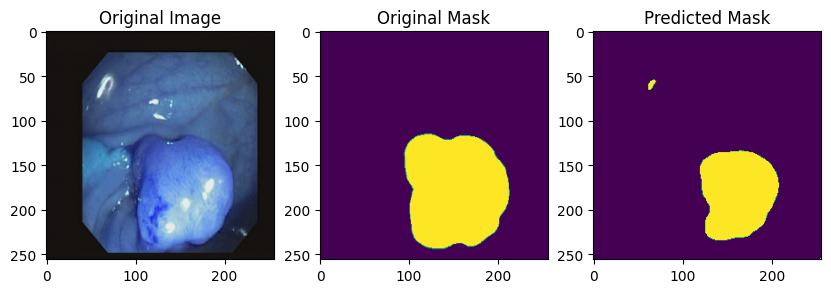

In [37]:
import random
dice_scores = []
for test_path, test_mask_path in zip(test_paths, test_mask_paths):
    # read the image and mask using OpenCV
    test_image = cv2.imread(test_path)
    ground_truth_test_image = cv2.imread(test_mask_path, 0)  # read the mask as grayscale

    # resize the image and mask to the desired dimensions
    test_image = cv2.resize(test_image, (256, 256))
    ground_truth_test_image = cv2.resize(ground_truth_test_image, (256, 256))

# normalize the image and mask to have values between 0 and 1

    test_image = test_image / 255.0
    ground_truth_test_image= ground_truth_test_image / 255.0


    # add the image and mask to the corresponding arrays
    test_images.append(test_image)
    ground_truth_test_images.append(ground_truth_test_image)


#by the end of this line, I have superpixeled images.
# convert the images and masks to numpy arrays
test_images = np.array(test_images)
ground_truth_test_images = np.array(ground_truth_test_images)
print(test_images.shape)
print(ground_truth_test_images.shape)
# add a channel dimension to the masks
# ground_truth_test_images = np.expand_dims(ground_truth_test_images, axis=-1)

# model.load_weights("{}_soft_label.best.hdf5".format('cxr_reg'))
# model.load_weights("{}_double_Unet_superpixel_skin_quick_shift.best.hdf5".format('cxr_reg'))
# model.load_weights("{}_double_Unet_superpixel_skin_sorted_list_slic800.best.hdf5".format('cxr_reg'))
model.load_weights("{}_Unet_superpixel_kvasir_slic800.best.hdf5".format('cxr_reg'))

# Make predictions
# predicted_masks = model.predict(test_images)
tf.config.run_functions_eagerly(True)
predicted_masks = model.predict(
    test_images,
    batch_size=1,
    verbose=1,
    steps=None,
    callbacks=None
)

predicted_mask_array = np.array(predicted_masks)
print(predicted_mask_array.shape)

# Convert the NumPy array to uint8 format
predicted_mask_array = (predicted_mask_array * 255).astype(np.uint8)
print(predicted_mask_array.shape)

#
dst = np.empty([predicted_mask_array.shape[0],predicted_mask_array.shape[1],predicted_mask_array.shape[2]])
kernel = np.ones((5,5),np.float64)/25
# dst = predicted_mask_array

#
for i in range(predicted_mask_array.shape[0]):

        threshold_value = 1
        _, dst[i] = cv2.threshold(predicted_mask_array[i], threshold_value, 255, cv2.THRESH_BINARY)
        dst[i] = np.array(dst[i])
        dst[i] = tf.convert_to_tensor(dst[i] / 255.0,dtype=predicted_masks.dtype)

print(dst.shape)

## Cast the input tensor to a double tensor
ground_truth_test_images = tf.cast(ground_truth_test_images, dtype=tf.float64)
predicted_masks = tf.cast(dst, dtype=tf.float64)
# predicted_masks = tf.cast(predicted_mask_array, dtype=tf.float64)
# Apply thresholding

dice_scores = []  # List to store the dice coefficients
precision_scores = []
sensitivity_scores = []
iou_scores = []

# Iterate over the images and calculate the dice coefficient
for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    dice = dice_coef(y_true, y_pred)
    dice_scores.append(dice)

# Compute the average dice coefficient
average_dice = np.mean(dice_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]
    
    precision_value = precision(y_true, y_pred)
    precision_scores.append(precision_value)

# Compute the average dice coefficient
average_precision = np.mean(precision_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    sensitivity_value = sensitivity(y_true, y_pred)
    sensitivity_scores.append(sensitivity_value)

# Compute the average dice coefficient
average_sensitivity = np.mean(sensitivity_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    iou_value = iou(y_true, y_pred)
    iou_scores.append(iou_value)

# Compute the average dice coefficient
average_iou = np.mean(iou_scores)

# dice_score = dice_coef(ground_truth_test_images, dst)
# precision_val = precision(ground_truth_test_images, dst)
# sensitivity_val = sensitivity(ground_truth_test_images, dst)
# iou_val = iou(ground_truth_test_images, dst)
# print(type(dst))

print("Dices:", dice_scores)
print("Dice coefficient:", average_dice)
print("Precision:", average_precision)
print("Sensitivity:", average_sensitivity)
print("IoU:", average_iou)

# n =10 # number of images to show
# for i in range(n):
#     fig, ax = plt.subplots(1, 3, figsize=(10, 5))
#     ax[0].imshow(test_images[i])
#     ax[0].set_title('Original Image')
#     ax[1].imshow(ground_truth_test_images[i])
#     ax[1].set_title('Original Mask')
#     ax[2].imshow(dst[i])
#     ax[2].set_title('Predicted Mask')
#     plt.show()

total_images = len(test_images)

n = 10
# Randomly select 10 indices without replacement
random_indices = random.sample(range(total_images), n)

# Display the selected images and their masks
for i in random_indices:
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(test_images[i])
    ax[0].set_title('Original Image')
    ax[1].imshow(ground_truth_test_images[i])  # Display the original mask in grayscale
    ax[1].set_title('Original Mask')
    ax[2].imshow(dst[i])  # Display the predicted mask in grayscale
    ax[2].set_title('Predicted Mask')
    plt.show()


Launching TensorBoard...